In [1]:
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

%matplotlib inline

##### Exercise 6.1   

Can you imagine a scenario in which a TD update would be better on average than an Monte Carlo update? 

As suggested in the hint, if the Value function at a particular state were very accurate due to prior experience, TD updates to the prior states would make the Value functions of the prior states converge quicker to the real Value function. If you do an every-visit Monte Carlo, you would update the value function in a sub-optimal way since $R_t$ is only observed after 1-episode, whereas bootstrapping with Value functions incorporates prior knowledge into the updates.


##### Exercise 6.2

From Figure  6.6, it appears that the first episode results in a change in only $V(A)$. What does this tell you about what happened on the first episode? Why was only the estimate for this one state changed? By exactly how much was it changed?

The TD(0) update is $V(s_t) \leftarrow V(s_t) + \alpha [r_{t+1} + \gamma V(s_{t+1}) - V(s_t)]$, so after the first episode, the random walker started at C and terminated immediately after going left past A. The $V(C)$ and $V(B)$ don't change after the first episode since $r_{t+1}$ is 0 and $V(C) - V(B) = .5 - .5 = 0$, etc. However, $V(A)$ is updated as $V(A) = V(A) + \alpha [0 + \gamma \cdot 0 - 0.5] = V(A) - \alpha \cdot 0.5$.

##### Exercise 6.3

Do you think that by choosing the step-size parameter, , differently, either algorithm could have done significantly better than shown in Figure  6.7? Why or why not?
 
The $\alpha$ parameter specifies the weight updated to the value functions. As $\alpha$ increases, we expect TD(0) and Every-visit MC to make larger updates to the value functions, and as $\alpha$ decreases, the updates are smaller. Keeping the number of episodes fixed, the RMSE over states is minimized for some $\alpha$, but I'm not sure if the $\alpha$ is unique. If $\alpha$ were unique, the RMSE in $\alpha$ may be convex (since $V*$ is a fixed point), and the optimal $\alpha$ for the MC plot is within the range already searched. For TD(0) it seems like lower $\alpha < 0.05$ may be more optimal to lower RMSE after 100 episodes.

##### Exercise 6.4

In Figure  6.7, the RMS error of the TD method seems to go down and then up again, particularly at high $\alpha$'s. What could have caused this? Do you think this always occurs, or might it be a function of how the approximate value function was initialized?

The TD(0) method with constant $\alpha$ doesn't actually converge to a fixed point. Equation 2.8 shows us that in order for TD(0) to converge for a stationary environment, $\sum_{k=1}^{\infty} \alpha_k \rightarrow \infty$ and $\sum_{k=1}^{\infty} \alpha_k^2 \lt \infty$. A constant value for $\alpha$ fails the second condition, thus irregardless of the initilization of the value function, the RMSE will not converge to a minimum over time and will constantly vary. For small $\alpha$, it seems like TD(0) does not vary after reaching a minimum within the first 100 episodes in Figure 6.7.

##### Exercise 6.5
Above we stated that the true values for the random walk task are 1/6, 2/6, 3/6, 4/6, 5/6 for states A through E. Describe at least two different ways that these could have been computed. Which would you guess we actually used? Why?

One way would be to use dynamic programming since the random walk in Figure 6.5 is a finite-state MDP. Another method, is to realize that the task is undiscounted and episodic, so the value of each state is the probability of reaching the terminal state that has reward 1 (since all rewards are 0 except at the right-most terminal state). Therefore it is easy to compute the value of state C, since the problem is symmetrical, the probability of reaching any terminal state is 0.5, so the value is $0.5 \cdot 0 + 0.5 \cdot 1 = 0.5$. Then we know that $V(D) = 0.5 \cdot V(E) + 0.5 \cdot V(C)$ and $V(E) = 0.5 \cdot 1 + 0.5 \cdot V(D)$; plugging the $V(E)$ equation into $V(D)$, we get $V(D) = 0.5 (0.5 + 0.5 \cdot V(D)) + 0.25$, so $V(D) = \frac{.5}{.75} = \frac{4}{6}$ and $V(E) = \frac{5}{6}$. A similar exercise can be done with $V(B)$ and $V(A)$, or by symmetry we can see that $V(A) = 1 - V(E)$ and $V(B) = 1 - V(D)$.


##### Exercise 6.6 and 6.7, Windy grid world

It takes a lot longer for my SARSA to converge than the one in the book at 8000 time steps. I'm not sure why and I haven't been able to find a bug...


In [5]:

class WindyGridWorld(object):
    def __init__(self, grid, wind, stochastic_wind=False):
        """
            1: valid move
            2: start
            3: end
        """
        self.grid = grid
        self.wind = wind
        self.wind_is_stochastic = stochastic_wind
        self.row = 0
        self.column = 0
    
    def set_starting_state(self):
        w = np.where(self.grid == 2)
        self.row = w[0][0]
        self.column = w[1][0]
    
    def take_action(self, action):
        reward = -1
        random_wind = 0

        if self.wind_is_stochastic:
            random_wind = np.random.choice([-1, 0, 1], size=1, p=[1/3., 1/3., 1/3.])[0]
        
        # apply action
        d_row, d_column = action
        new_row = d_row + self.row
        new_column = d_column + self.column
        if not self.is_out_of_bounds(new_row, new_column):
            
            # apply wind        
            new_row_w_wind = new_row - self.wind[self.column] + random_wind
            if not self.is_out_of_bounds(new_row_w_wind, new_column):
                new_row = new_row_w_wind
            
            self.row = new_row
            self.column = new_column
        
        return reward
    
    def get_state(self):
        return (self.row, self.column)
    
    def get_states(self):
        return list(product(range(self.grid.shape[0]), range(self.grid.shape[1])))
    
    def is_terminal_state(self):
        if self.grid[self.row, self.column] == 3:
            return True
        return False
    
    def is_out_of_bounds(self, r, c):
        if r < 0 or r > self.grid.shape[0] - 1:
            return True
        
        if c < 0 or c > self.grid.shape[1] - 1:
            return True
        
        return False
    
    def get_regular_actions(self):
        return [(1, 0), (-1, 0), (0, 1), (0, -1)]
    
    def get_kings_actions(self):
        return list(set(product([-1, 0, 1], [-1, 0, 1])) - set([(0, 0)]))


In [93]:
class Solver(object):
    def __init__(self, environment, actions):
        self.environment = environment
        self.actions = actions
        self.states = environment.get_states()
        self.state_idx = {s: idx for idx, s in enumerate(self.states)}
        self.Q = np.random.random(size=(len(self.states), len(self.actions)))
        
    def SARSA(self, max_time_steps=8000, epsilon=0.1, alpha=0.1, gamma=1):
        self.Q = np.zeros((len(self.states), len(self.actions)))
        
        t = 0
        episode_history = [0]
        while t < max_time_steps:
            episode_history.append(episode_history[-1] + 1)
            self.environment.set_starting_state()
            s = self.environment.get_state()
            a = self.get_epsilon_greedy_action(s, epsilon)

            while not self.environment.is_terminal_state() and t < max_time_steps:
                episode_history.append(episode_history[-1])
                r = self.environment.take_action(self.actions[a])
                s_prime = self.environment.get_state()
                a_prime = self.get_epsilon_greedy_action(s_prime, epsilon)
                self.Q[self.state_idx[s], a] += alpha * \
                    (r + gamma * self.Q[self.state_idx[s_prime], a_prime] - self.Q[self.state_idx[s], a])
                s = s_prime; a = a_prime
                t += 1

        return episode_history
            
    def get_epsilon_greedy_action(self, s, epsilon=0.1):
        s_idx = self.state_idx[s]
        u_rand = np.random.random()
        if u_rand < epsilon:
            return np.random.randint(low=0, high=len(self.actions))
        action_idx = np.where(self.Q[s_idx,:] == np.amax(self.Q[s_idx,:]))[0]
        return np.random.choice(action_idx)
    
    def get_greedy_episode(self, max_iter=20):
        self.environment.set_starting_state()
        s = self.environment.get_state()

        g_orig = self.environment.grid
        g = np.copy(g_orig)
        g[s[0], s[1]] = -1
        print(g)
    
        t = 0
        while not self.environment.is_terminal_state() and t < max_iter:
            a = self.get_epsilon_greedy_action(s, epsilon=0)
            print('taking action', a)
            r = self.environment.take_action(self.actions[a])
            s = self.environment.get_state()
            g = np.copy(g_orig)
            g[s[0], s[1]] = -1
            print(g)
            t += 1


In [94]:
grid = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 1, 1, 1, 1, 1, 1, 3, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ])
wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])

In [109]:

max_time_step = 80000
# Regular Wind
gw = WindyGridWorld(grid, wind, stochastic_wind=False)
solver = Solver(gw, gw.get_regular_actions())
num_episodes_regular = solver.SARSA(max_time_steps=max_time_step, alpha=0.1)
solver = Solver(gw, gw.get_kings_actions())
num_episodes_kings = solver.SARSA(max_time_steps=max_time_step, alpha=0.05)

# Stochastic Wind
gw = WindyGridWorld(grid, wind, stochastic_wind=True)

solver = Solver(gw, gw.get_regular_actions())
num_episodes_regular_stochastic = solver.SARSA(max_time_steps=max_time_step, alpha=.05)
solver = Solver(gw, gw.get_kings_actions())
num_episodes_kings_stochastic = solver.SARSA(max_time_steps=max_time_step, alpha=.05)


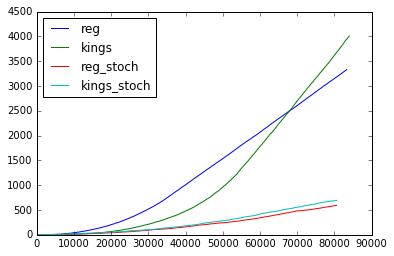

In [111]:
plt.plot(num_episodes_regular)
plt.plot(num_episodes_kings)
plt.plot(num_episodes_regular_stochastic)
plt.plot(num_episodes_kings_stochastic)
plt.legend(['reg', 'kings', 'reg_stoch', 'kings_stoch'], loc='best')

##### Exercise 6.8

The backup diagram for Sarsa is simply an $(s, a)$ node that gets a reward pointing to another $(s', a')$ node.


##### Exercise 6.9 

Q-learning is an off-policy control method since $Q(s,a)$ is not updated based on the actual next state $s'$ and action $a'$ taken by the agent. In Q-learning, $Q(s,a)$ is being updated based on greedy actions that may have not been taken by the agent.

##### Exercise 6.10

The proposed algorithm is off-policy since $Q(s,a)$ is not being updated by the next state-action pair that the agent takes, but insead the average over future state-actions. The backup diagram looks similar to Q-learning, except the sweep over next actions is an average. I'd expect this method to work better than Sarsa since the average over multiple future next state-actions is incorporated into the update instead of the state-action that the agent actually  (more information is incorporated into the update).

##### Exercise 6.11

Design an on-policy R-learning method for undiscounted continuing tasks. 

This would be similar to the off-policy method in Chapter 6.7 since the algorithm shown is also undiscounted and continuing. I'm not really sure about the estimation policy, since in Figure 6.16 it is greedy, whereas here it needs to be on-policy:


- Initialize $s$ at current state
- Choose $a$ from $s$ using behavioral policy from $Q$
- Repeat
    - Take $a$ and observe $r, s'$
    - Choose $a'$ from $s'$ using behavioral policy from $Q$
    - $Q(s,a) \leftarrow Q(s,a) + \alpha[r - \rho + Q(s',a') - Q(s,a)]$
    - $\rho \leftarrow \rho + \beta[r - \rho + Q(s',a') - Q(s,a)]$ (not sure about this step)
    - $a \leftarrow a'$ and $s \leftarrow s'$



##### Exercise 6.12

Describe how the task of Jack's Car Rental (Example 4.2) could be reformulated in terms of afterstates. Why, in terms of this specific task, would such a reformulation be likely to speed convergence?

In Jack's Car Rental, the actions deterministically result in the number of cars available for rent the next day (the afterstates). However the states used in DP are the number of cars available at the end of the day. A reformulation using afterstates of Value Iteration to solve Jack's Car Rental may speed up convergence, since the value of the afterstates only depends on the demand distribution and not the actions that Jack took to get to the afterstate. Several states and actions that generate the same afterstates all have the same value, and the demand for cars converges to a known distribution; the $V(s_{after})$ is calculated only off of the demand, rather than Jack's action and then the demand.